In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600


# Load the JSONL file
# Load only necessary columns to reduce memory usage
# Adjust columns list based on what you need from the dataset
columns = ["Element", "Ox", "CN", "Geometry", "Charge", "MW", "Ligand_multiset_variants"]

# Read in chunks and filter/sample if needed
chunk_size = 10000
chunks = []
for chunk in pd.read_json('dataset.jsonl', lines=True, chunksize=chunk_size):
    chunk = chunk[columns]  # Keep only needed columns
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Print the columns
print(df.columns)

Index(['Element', 'Ox', 'CN', 'Geometry', 'Charge', 'MW',
       'Ligand_multiset_variants'],
      dtype='object')


In [2]:
next(iter(pd.read_json('dataset.jsonl', lines=True, chunksize=100)))

,Element,Ox,CN,Geometry,Charge,Ligand_multiset_variants,MW,count_type_halide,count_type_methyl,count_type_methanediide,...,count_var_amine_N,count_var_imido_N,count_var_water_N,count_var_hydroxyl_N,count_var_oxo_N,count_var_phosphine_N,count_var_phosphido_N,count_var_hydrogen sulfide_N,count_var_thiol_N,count_var_sulfido_N
0,Fe,0,1,single,0,[halide|N],91.291,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fe,0,1,single,-1,[methyl|N],70.880,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Fe,0,1,single,0,[ammonia|N],72.877,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fe,0,1,single,-1,[amine|N],71.868,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Fe,0,1,single,0,[water|N],73.862,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Fe,0,2,linear,0,"[water|N, hydrogen sulfide|N]",107.939,0,0,0,...,0,0,1,0,0,0,0,1,0,0
96,Fe,0,2,linear,-1,"[water|N, thiol|N]",106.930,0,0,0,...,0,0,1,0,0,0,0,0,1,0
97,Fe,0,2,linear,0,"[water|N, sulfido|N]",105.921,0,0,0,...,0,0,1,0,0,0,0,0,0,1
98,Fe,0,2,linear,-1,"[hydroxyl|N, phosphine|N]",106.853,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [3]:
def plot_2d_histogram(df, col_x, col_y, figsize=(8.5,6), cmap='Blues', fontsize=14, log_scale=False):
    """
    Plots a 2D histogram (heatmap) of counts for two columns in a pandas DataFrame,
    treating both columns as categorical with bins equal to the number of unique values.
    
    Parameters:
    -----------
    col_x : str or list of str
        Column name(s) for the x-axis. If a list, values are combined with '|' separator.
    col_y : str
        Column name for the y-axis.
    figsize : tuple
        Figure size (width, height).
    cmap : str
        Colormap name.
    fontsize : int
        Font size for labels and ticks.
    log_scale : bool
        If True, use logarithmic color scale. Default is False.
    """
    # Handle col_x as either a single column or list of columns
    if isinstance(col_x, list):
        # Combine multiple columns into a single series with '|' separator
        x_series = df[col_x].astype(str).agg(''.join, axis=1)
        x_label = ''.join(col_x)
    else:
        x_series = df[col_x]
        x_label = col_x
    
    x_unique = sorted(x_series.unique())
    y_unique = sorted(df[col_y].unique())
    x_map = {v: i for i, v in enumerate(x_unique)}
    y_map = {v: i for i, v in enumerate(y_unique)}
    x_vals = x_series.map(x_map)
    y_vals = df[col_y].map(y_map)
    x_bins = np.arange(len(x_unique) + 1) - 0.5
    y_bins = np.arange(len(y_unique) + 1) - 0.5

    plt.figure(figsize=figsize)
    
    # Set up normalization based on log_scale parameter
    if log_scale:
        from matplotlib.colors import LogNorm
        # First compute histogram to get counts for setting norm bounds
        counts_pre, _, _ = np.histogram2d(x_vals, y_vals, bins=[x_bins, y_bins])
        vmin = max(1, counts_pre[counts_pre > 0].min()) if (counts_pre > 0).any() else 1
        vmax = counts_pre.max() if counts_pre.max() > 0 else 1
        norm = LogNorm(vmin=vmin, vmax=vmax)
        counts, xedges, yedges, im = plt.hist2d(x_vals, y_vals, bins=[x_bins, y_bins], cmap=cmap, norm=norm)
    else:
        counts, xedges, yedges, im = plt.hist2d(x_vals, y_vals, bins=[x_bins, y_bins], cmap=cmap)
        norm = im.norm if hasattr(im, 'norm') else plt.Normalize(vmin=counts.min(), vmax=counts.max())
    
    plt.xlabel(x_label, fontsize=fontsize)
    plt.ylabel(col_y, fontsize=fontsize)
    cbar = plt.colorbar(label='Count')
    cbar.ax.tick_params(labelsize=fontsize)

    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    plt.xticks(x_centers, x_unique, rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(y_centers, y_unique, fontsize=fontsize)

    cmap_obj = plt.get_cmap(cmap)

    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            count = int(counts[i, j])
            if count > 0:
                x_tick = x_centers[i]
                y_tick = y_centers[j]
                color_val = norm(count)
                rgba = cmap_obj(color_val)
                text_color = 'white' if rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114 < 0.5 else 'black'
                plt.text(x_tick, y_tick, f'{count:.1e}',
                         color=text_color, ha='center', va='center', fontsize=fontsize-5)

    plt.tight_layout()
    plt.show()
    return counts

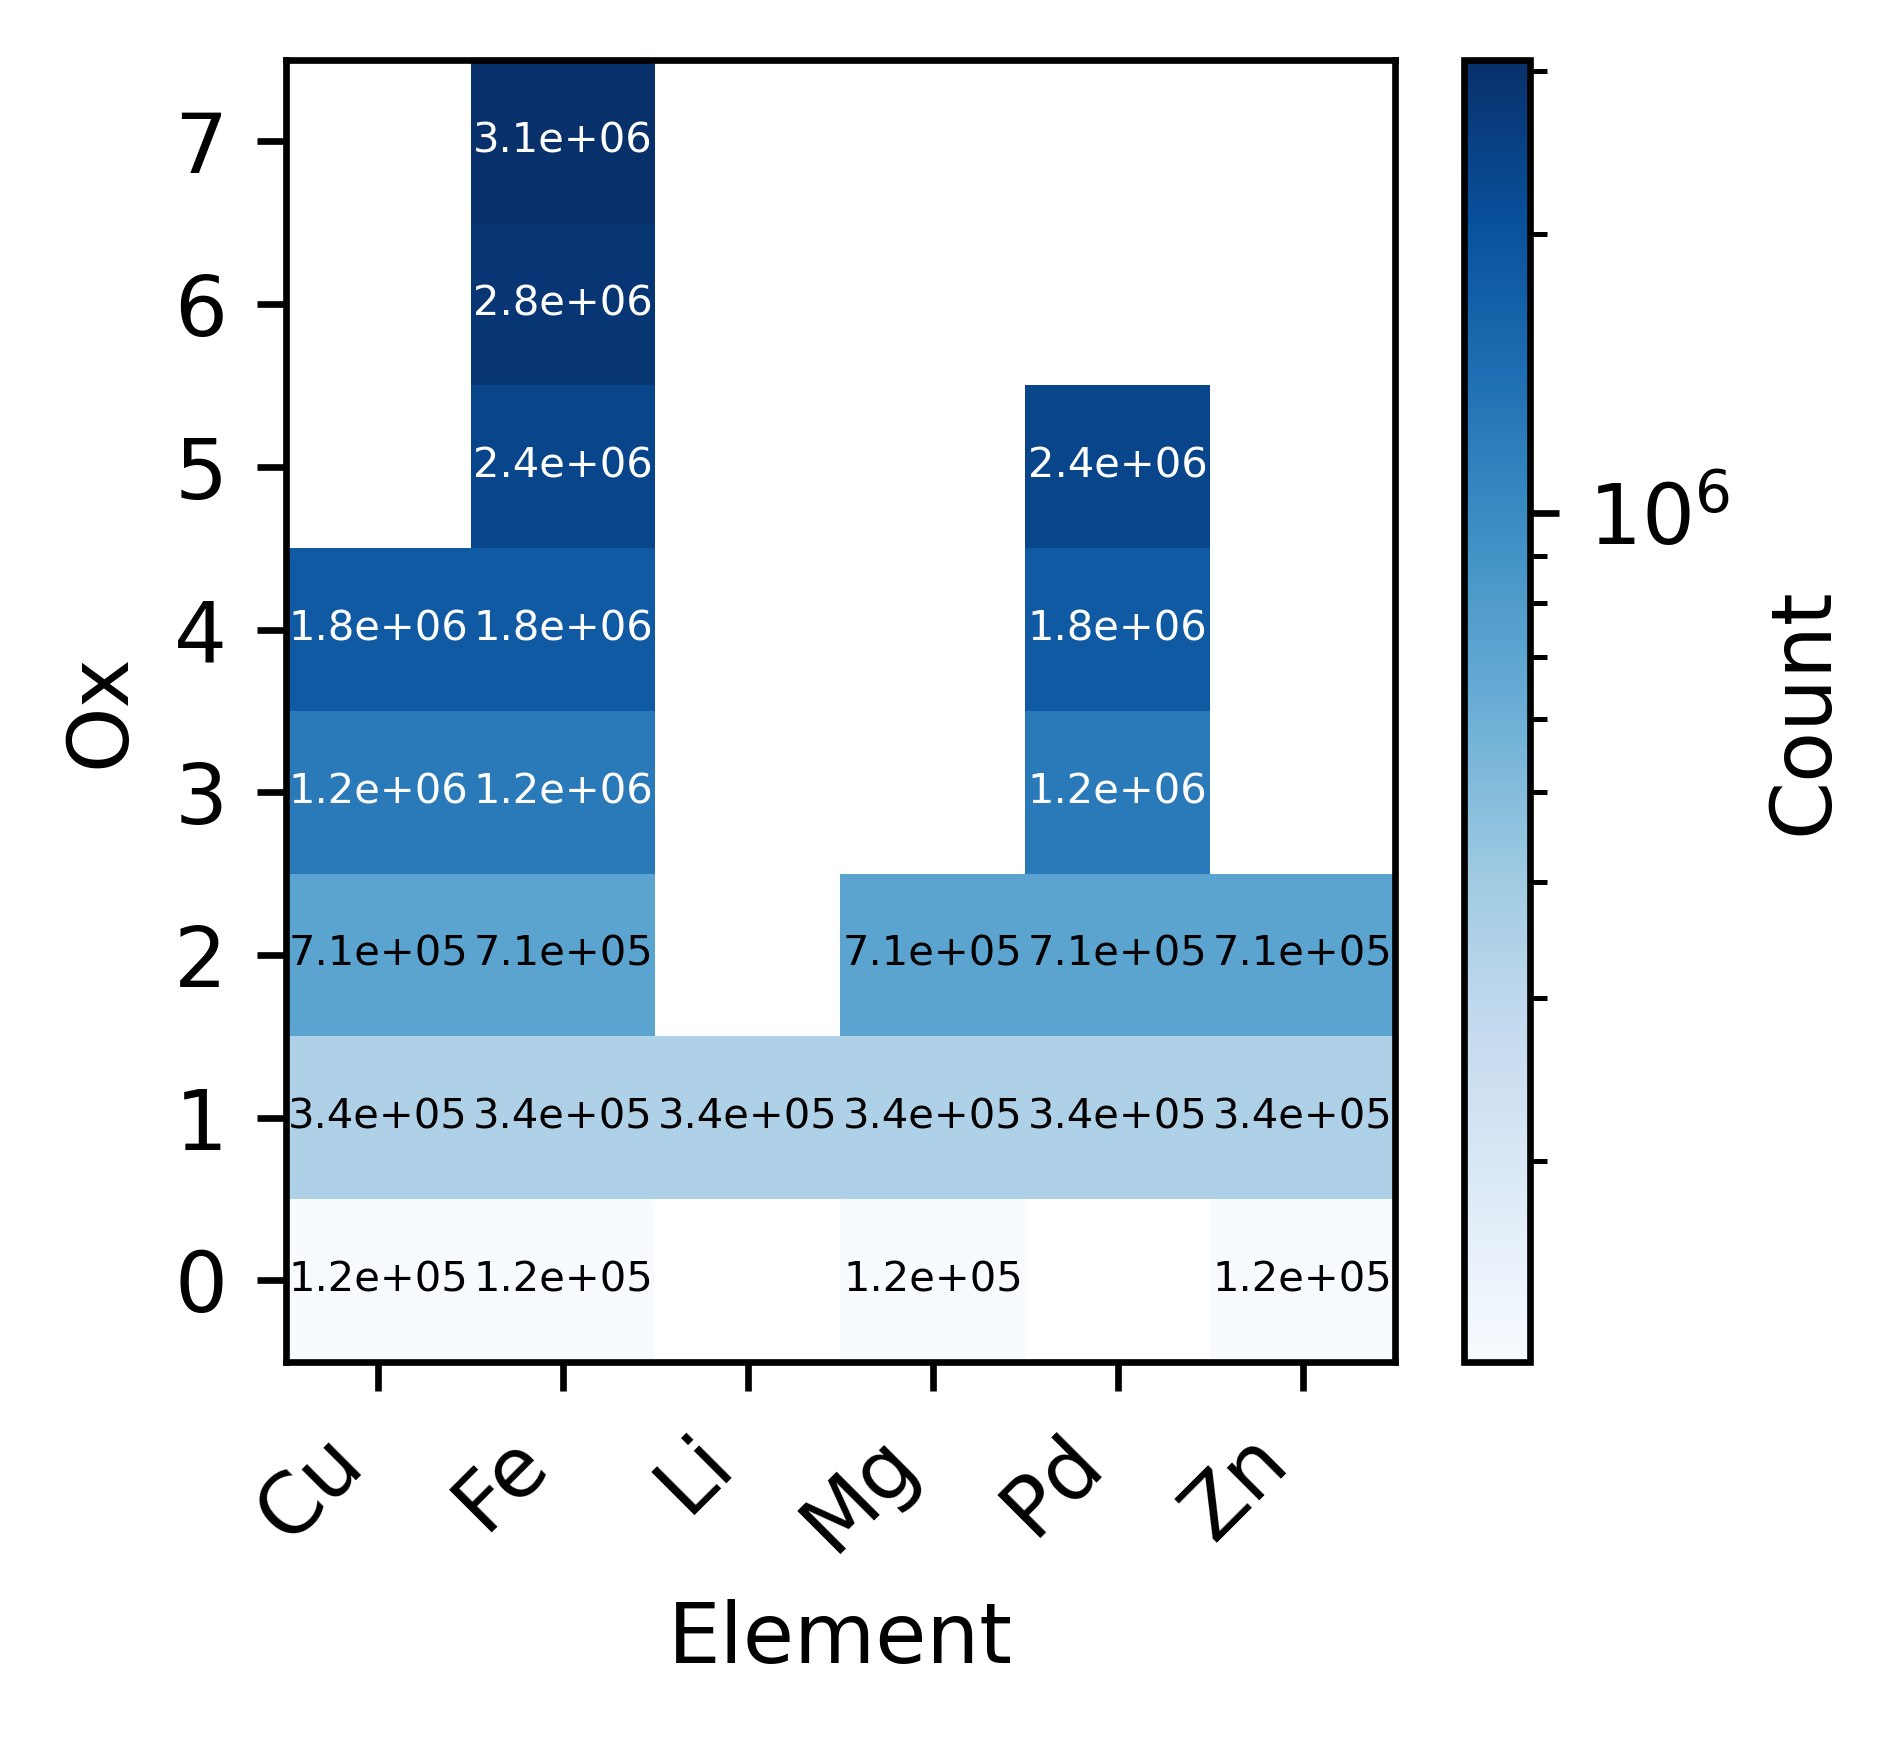

In [4]:
# columns = ["Element", "Ox", "CN", "Geometry", "Charge"]
plot_2d_histogram(df, columns[0], columns[1], figsize=(3.25, 3), fontsize=10, log_scale=True);

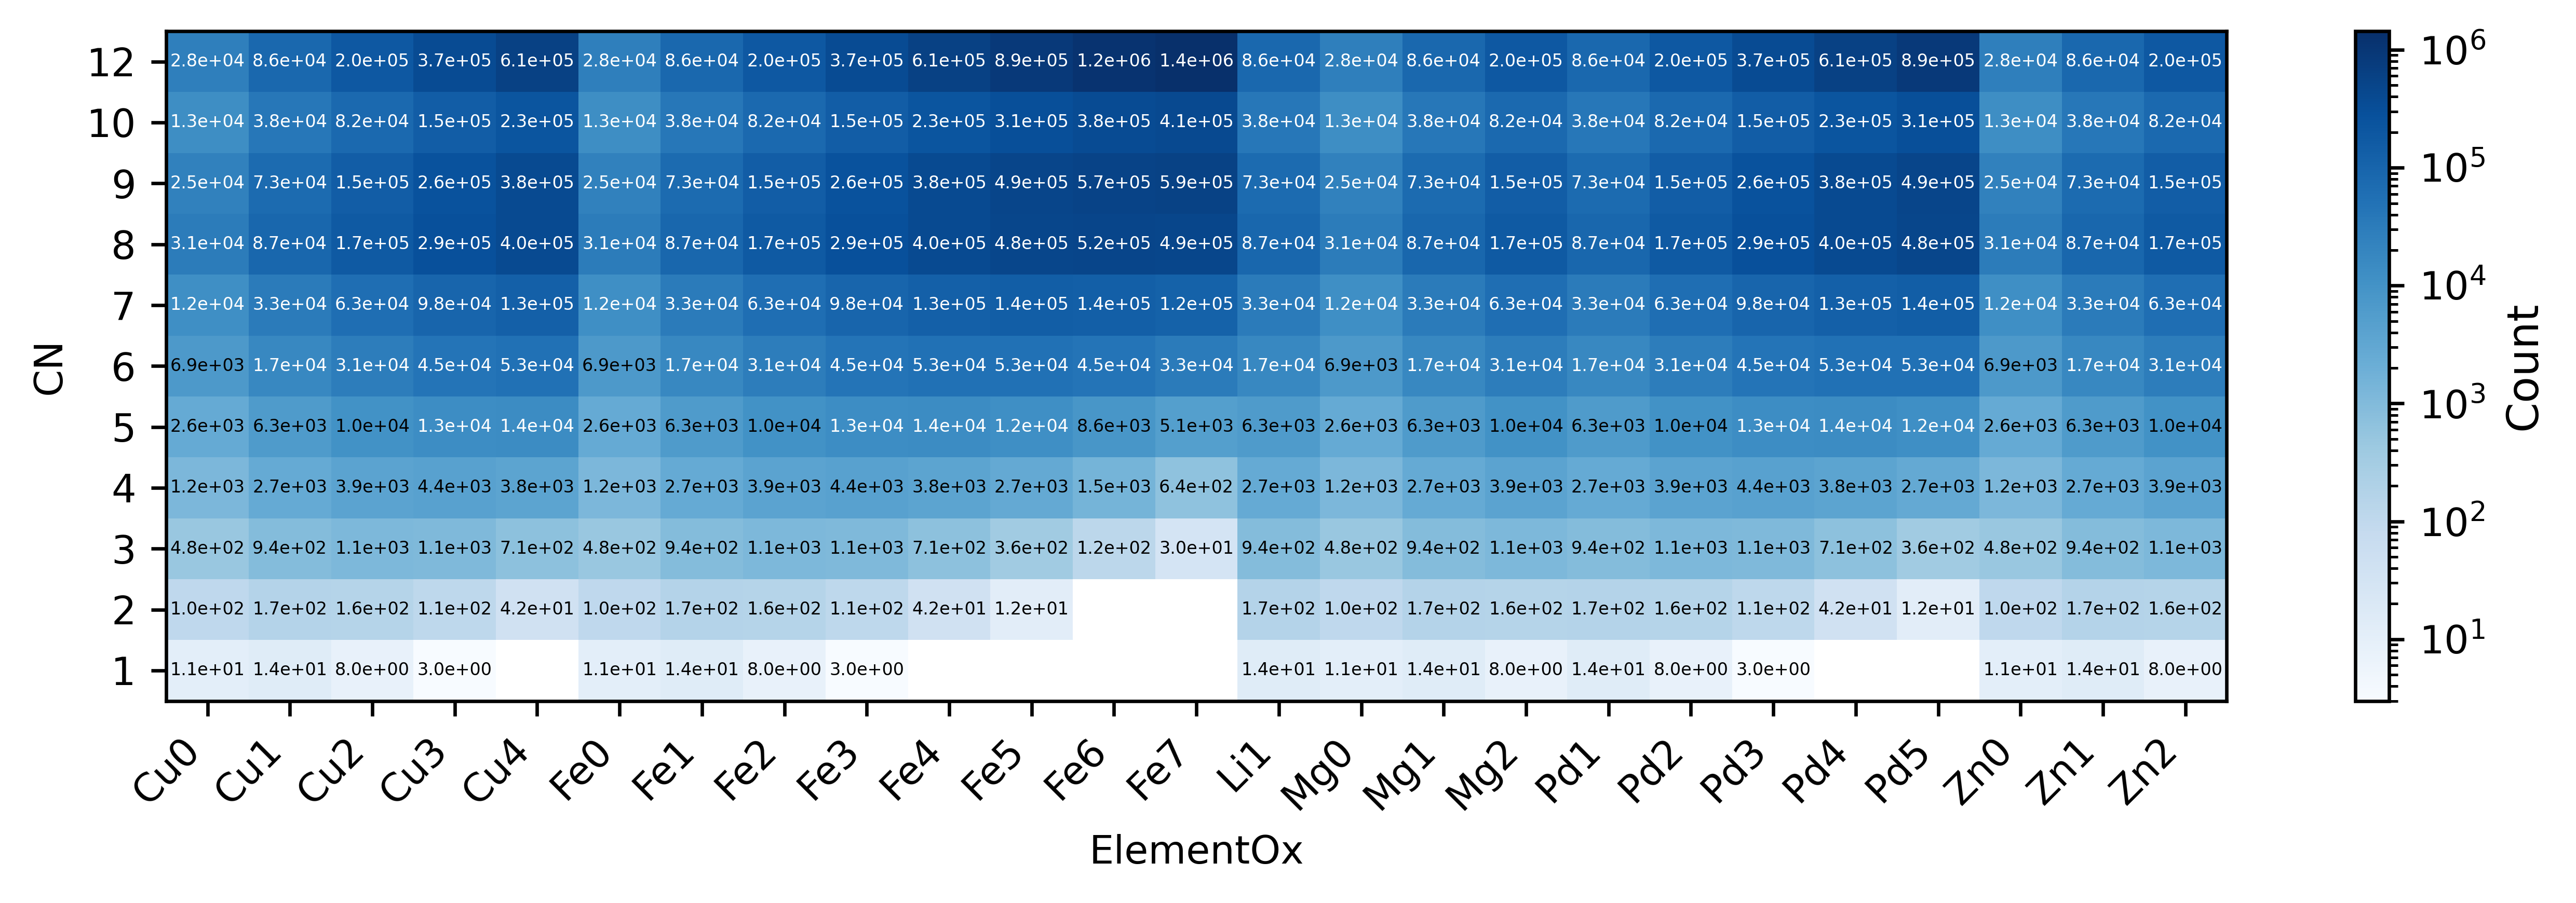

In [5]:
plot_2d_histogram(df, [columns[0], columns[1]], columns[2], figsize=(9, 3), fontsize=9, log_scale=True);

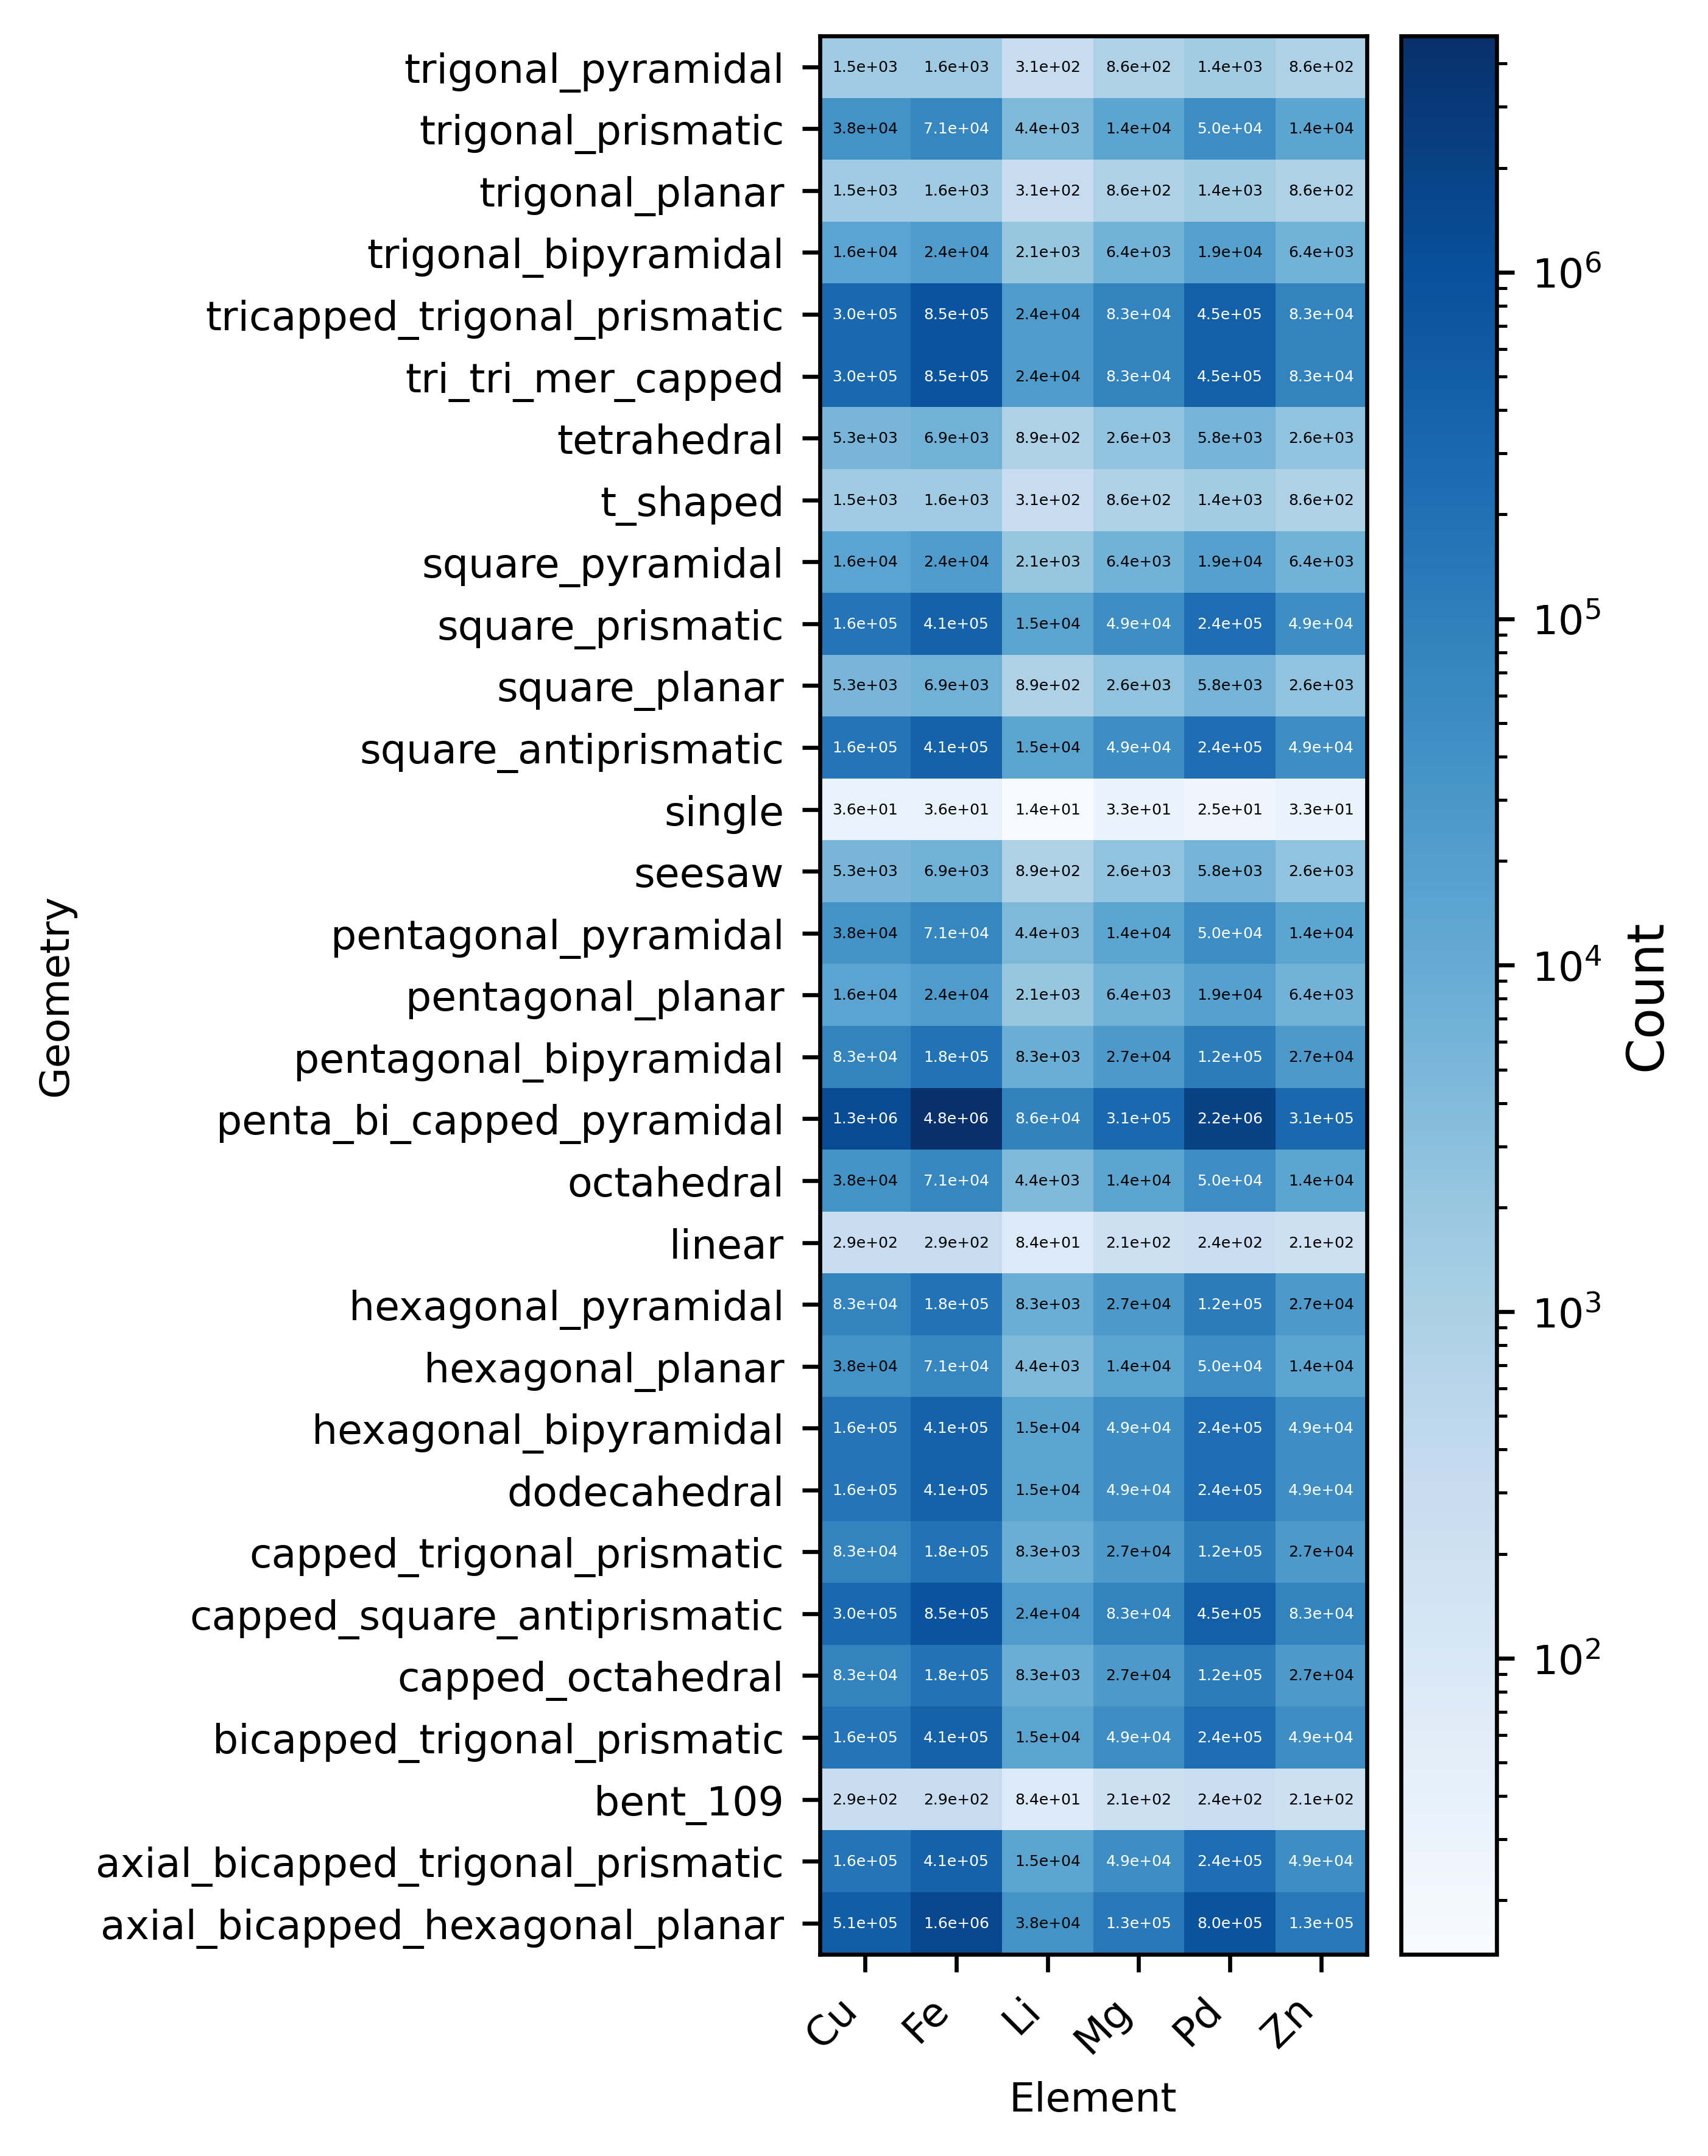

In [6]:
plot_2d_histogram(df, columns[0], columns[3], figsize=(4.5, 6), fontsize=8, log_scale=True);

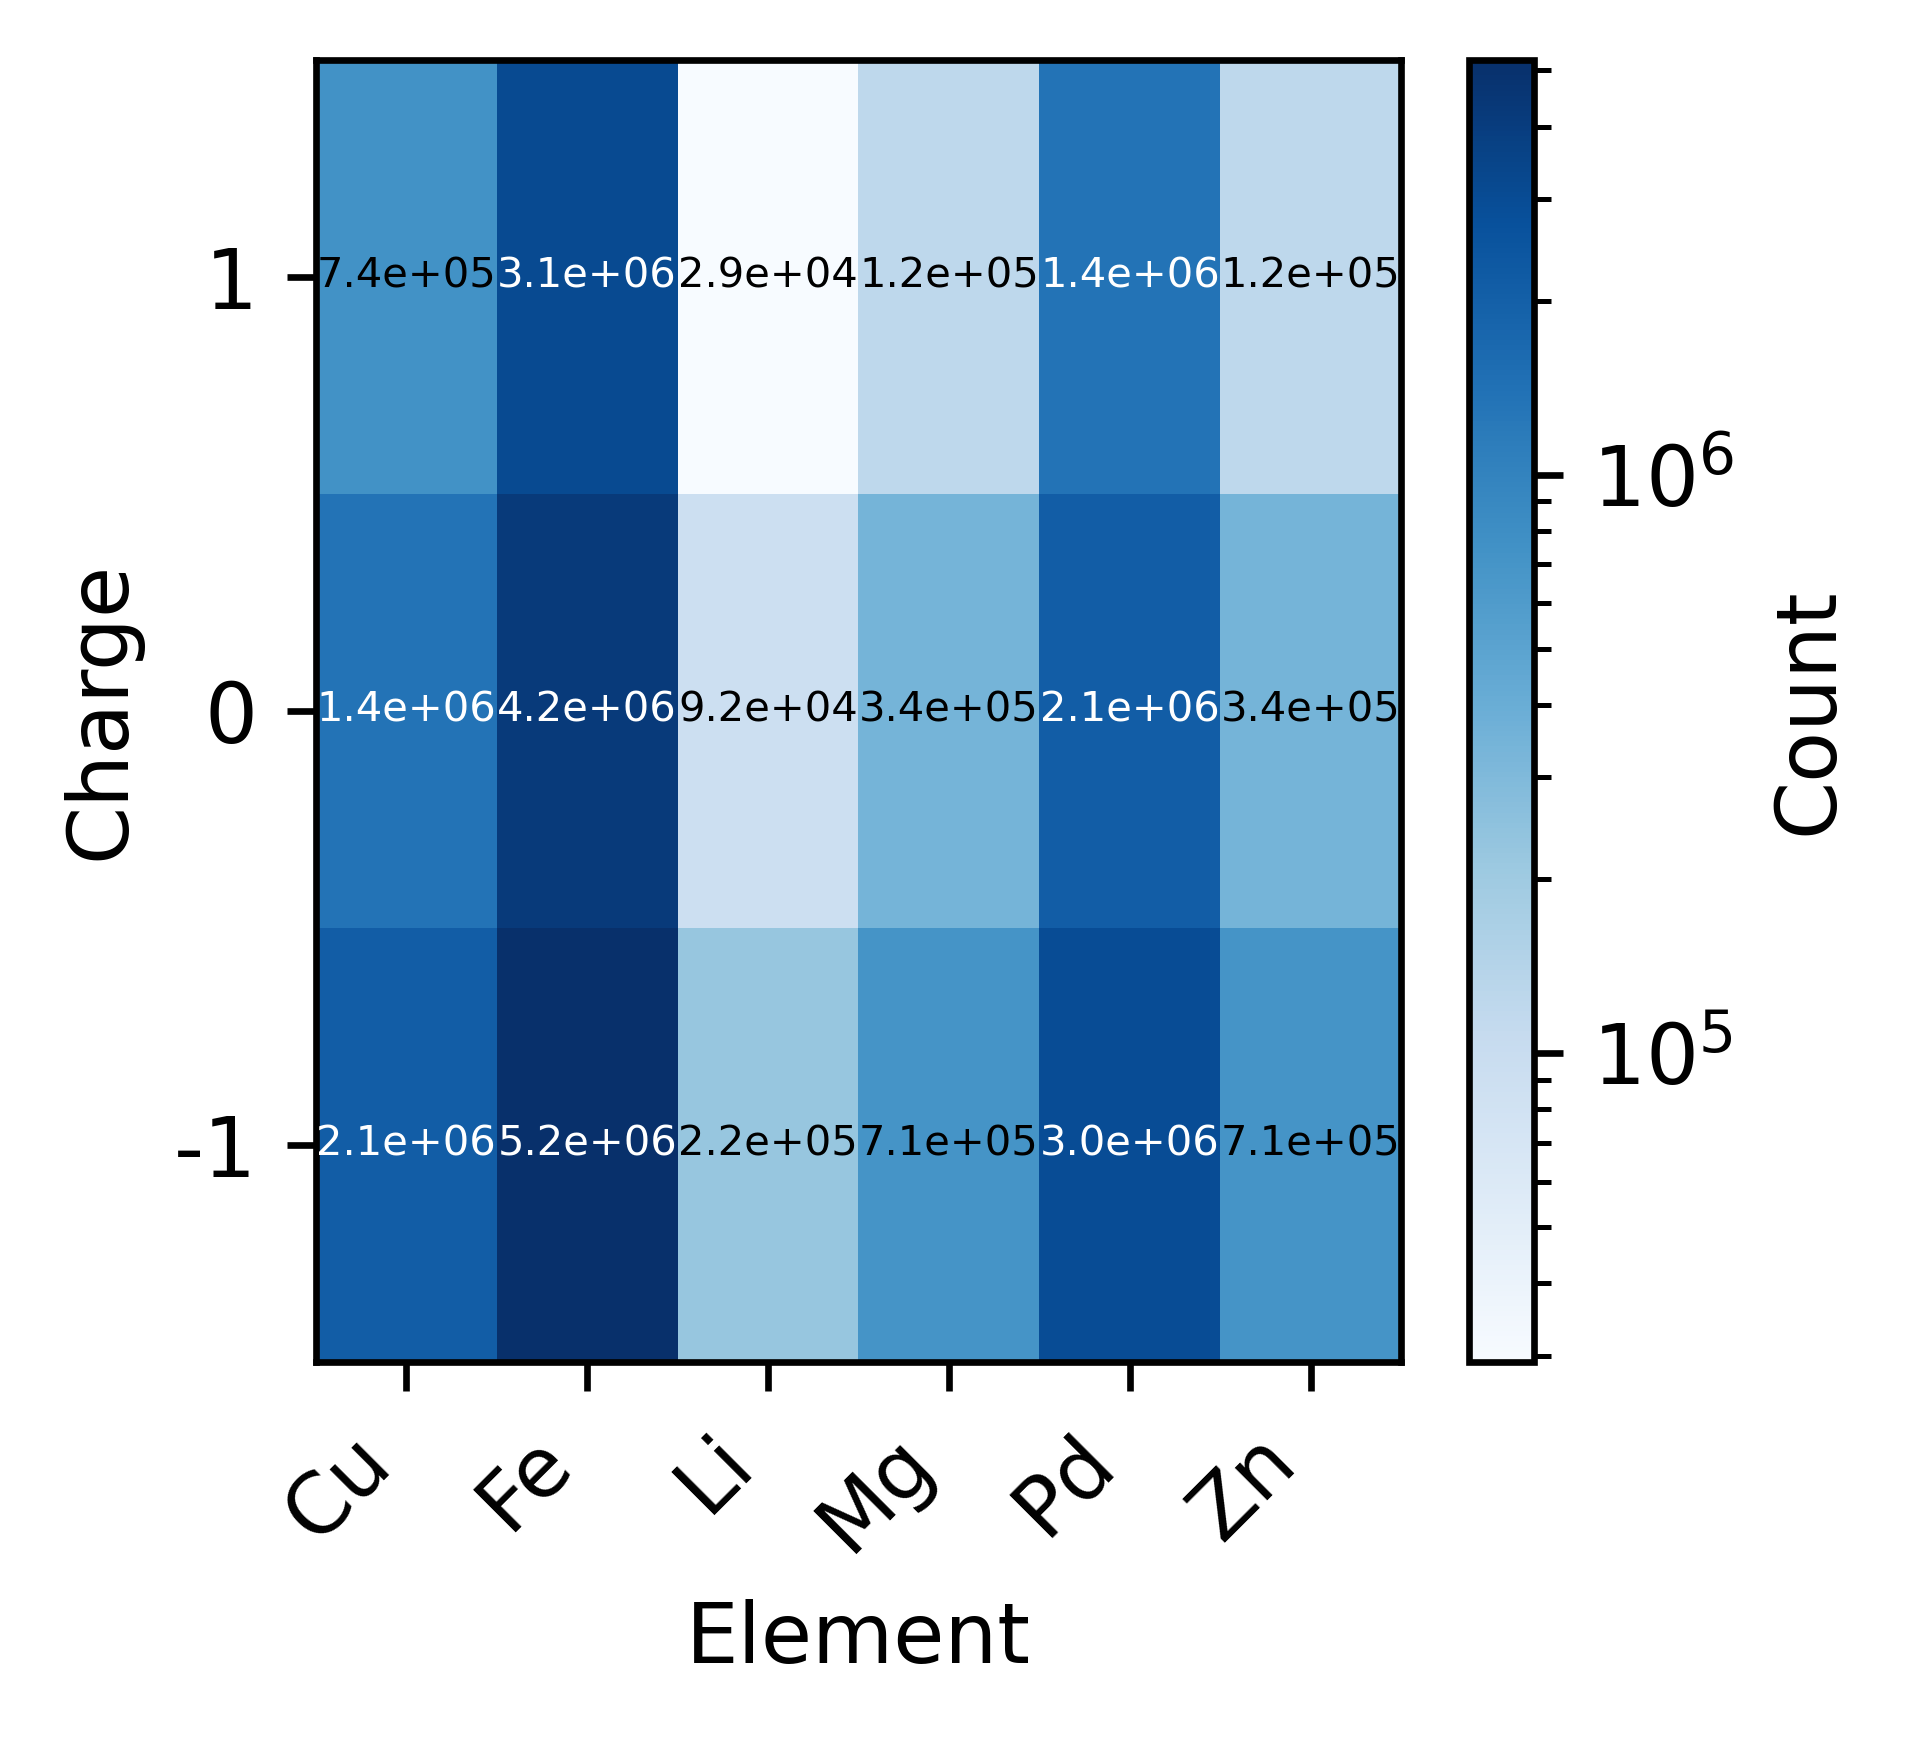

In [7]:
plot_2d_histogram(df, columns[0], columns[4], figsize=(3.25, 3), fontsize=10, log_scale=True);